# Fast irregular domain node layout
### John H. Williamson 2018
#### MIT license (see LICENSE)

Implements the ["Fast generation of 2-D node distributions for mesh-free PDE discretizations" algorithm by [Fornberg and Flyer]( https://amath.colorado.edu/faculty/fornberg/Docs/2015_FF_Node_placing_CMA.pdf)

>Fornberg, B., & Flyer, N. (2015). Fast generation of 2-D node distributions for mesh-free PDE discretizations. Computers & Mathematics with Applications, 69(7), 531-544.

### Limitations
This only implements the code for laying out points in a rectangular domain. The paper presents a method for an iterative repulsion model to clean up edges when non-rectangular regions are cut out; this is not implemented here.


In [1]:
import numpy as np
from variable_density import moving_front_nodes

## Constant density test
Specifying a constant number of points in the unit area, test how many we get back. We are filling an area 1.0 unit square here,  so we should get about as many nodes in this area as the density function returns (we'll get slightly more due to edge effects).

In [2]:
for density in [10.0, 100.0, 500.0, 1000.0, 3000.0]:
    inv_density_fn = lambda x,y:  density * np.ones_like(x)
    nodes = moving_front_nodes(inv_density_fn, 
                           (-.5, -.5, 0.5, 0.5), new_pts=5, 
                           init_pts=1000)
    print("Expected constant density pts: %d actual points: %d" % (density, len(nodes)))

Expected constant density pts: 10 actual points: 9
Expected constant density pts: 100 actual points: 109
Expected constant density pts: 500 actual points: 513
Expected constant density pts: 1000 actual points: 1029
Expected constant density pts: 3000 actual points: 3061


## Test function
Simple test function; inv. square function

In [3]:
def inv_density_fn(x,y, k=0.00005):
    # spacing according to inverse squared exponential in this example    
    return (0.01+np.exp(-(x**2+y**2)**0.5*8.0)) / k


nodes = moving_front_nodes(inv_density_fn, 
                           (-1.0, -1.0, 1.0, 1.0), new_pts=5, 
                           init_pts=1000)
print(len(nodes)) # should be around 2800

2840


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('figure', figsize=(12.0, 12.0))

# Example plots

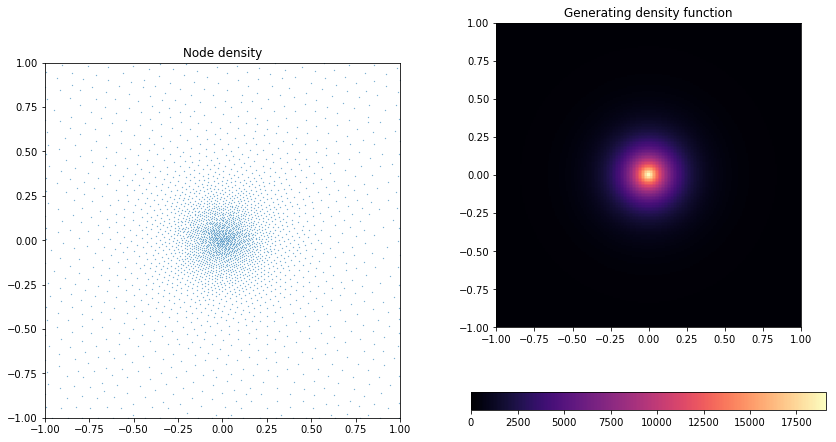

In [5]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,2,1)

# node layout
ax1.plot(nodes[:,0], nodes[:,1], '.', markersize=0.5)
ax1.axis("image")
ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax1.set_title("Node density")

# density function
ax2 = fig.add_subplot(1,2,2)
grid_space = np.linspace(-1,1,200)
grid_x, grid_y = np.meshgrid(grid_space, grid_space)
z = inv_density_fn(grid_x, grid_y)

zimg = ax2.imshow(z, extent=[-1,1,-1,1], cmap='magma', vmin=0)
ax2.set_title("Generating density function")
fig.colorbar(zimg, orientation='horizontal')

## Voronoi analysis
The **Delaunay** triangulation and the **Voronoi** diagram let us visualise the layout of the points. In particular, we'd expect the Voronoi diagram to have cells whose areas would have diameter/radius proportional to the density function we specified. 

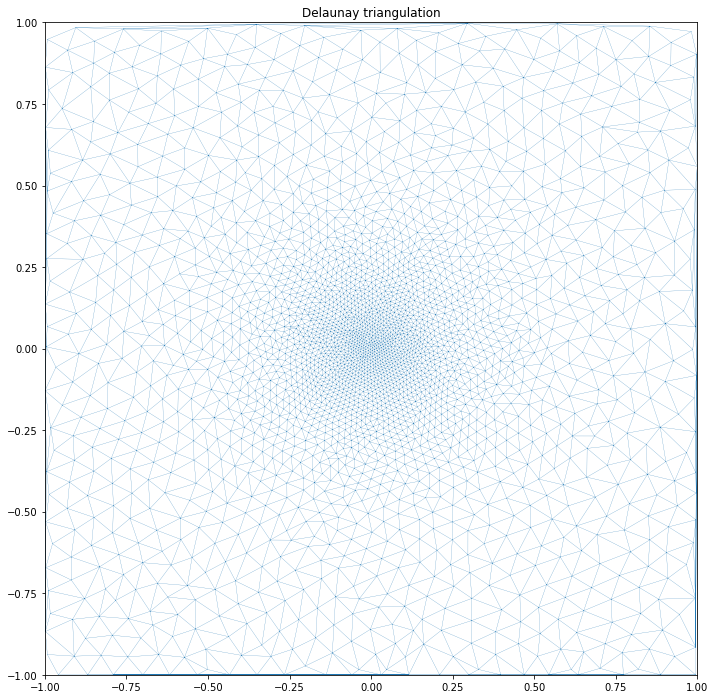

In [6]:
import scipy.spatial
tri = scipy.spatial.Delaunay(nodes,qhull_options='QJ')


plt.triplot(nodes[:,0], nodes[:,1], tri.simplices.copy(), lw=0.2)
plt.axis("image")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Delaunay triangulation")


## Voronoi

In [7]:
vor = scipy.spatial.Voronoi(nodes)

c:\conda3\lib\site-packages\scipy\spatial\_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


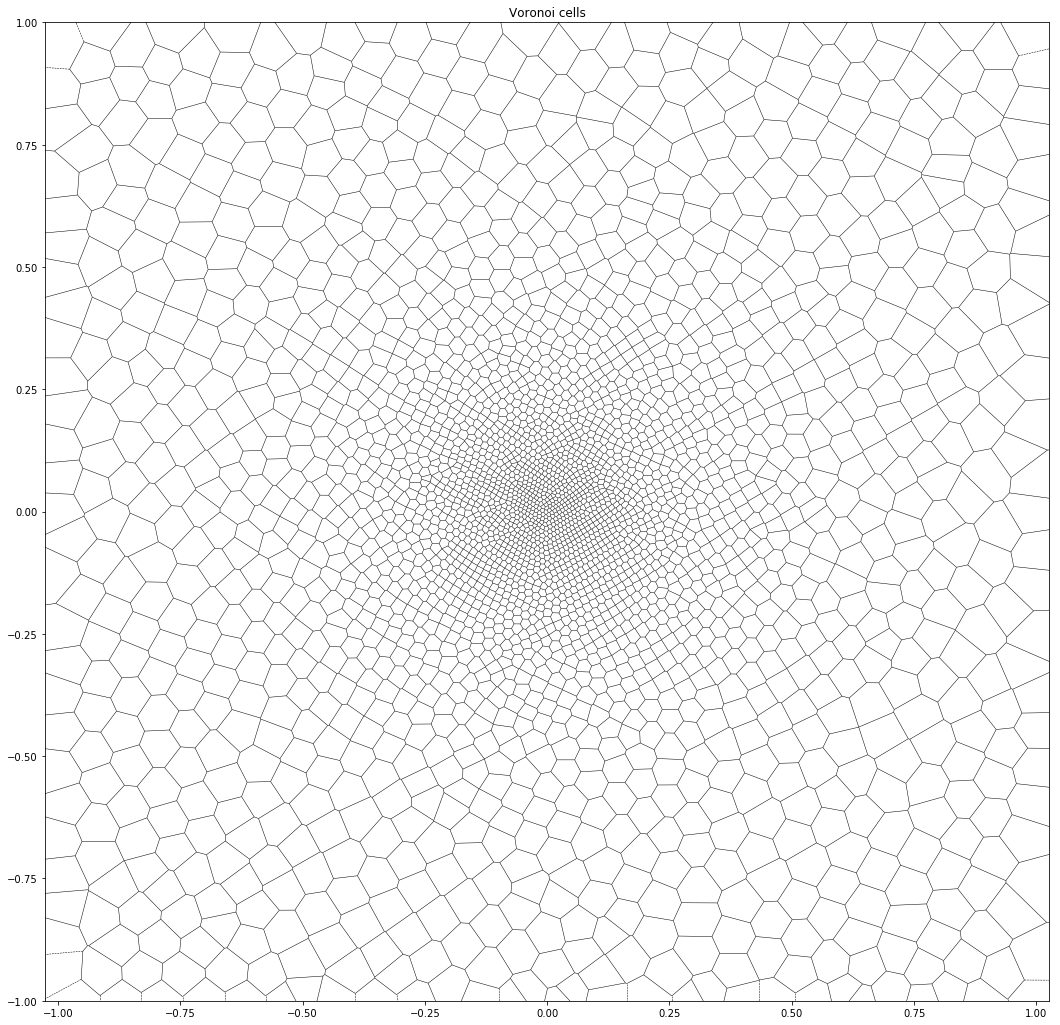

In [8]:
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(1,1,1)
scipy.spatial.voronoi_plot_2d(vor, show_vertices=False, show_points=False, ax=ax, line_width=0.5)

plt.axis("equal")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Voronoi cells")

### Quality metrics
We can plot the expected radius at each point $f(x,y)$ against the area of the Voronoi cell of that point to estimate how good a match the spacing is. 



We can also estimate the radius of the Voronoi cell from the statistics of the vertex distances (e.g. median inter-vertex distance), which should be approximately the square root of the area of the Voronoi cells.

In [9]:
# compute the area of each cell of the Voronoi tesselation

# area of a convex (actually any non-intersecting) polygon
def area(p):
    return 0.5 * abs(sum(x0*y1 - x1*y0
                         for ((x0, y0), (x1, y1)) in segments(p)))
def segments(p):
    return zip(p, p[1:] + [p[0]])

# create a new field in a Voronoi tesselation, which is the area of each polygon
# external polygons get an area of NaN
# also compute the min, mean, max and median distance between vertices of the polygons
def compute_area(vor):    
    vor.areas = []
    vor.min_diams = []
    vor.max_diams = []
    vor.mean_diams = []
    vor.median_diams = []
    
    for region in vor.point_region:    
        reg = np.array(vor.regions[region])
        if np.all(reg>=0) and np.all(reg<len(vor.vertices)):
            vtx = [vor.vertices[ix] for ix in reg]
            pdists = scipy.spatial.distance.pdist(vtx)
            vor.min_diams.append(np.min(pdists))
            vor.max_diams.append(np.max(pdists))
            vor.mean_diams.append(np.mean(pdists))
            vor.median_diams.append(np.median(pdists))
            a = area(vtx)        
            vor.areas.append(a)
        else:
            # external polygon
            vor.areas.append(np.nan)
            vor.min_diams.append(np.nan)
            vor.max_diams.append(np.nan)
            vor.mean_diams.append(np.nan)
            vor.median_diams.append(np.nan)
    vor.areas = np.array(vor.areas)
        


RMS error 3.125664278007007e-05


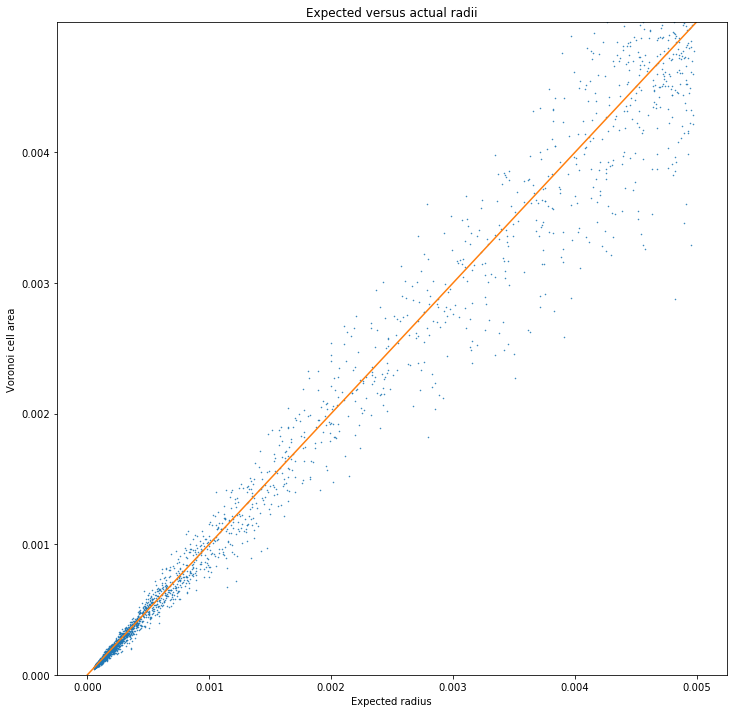

In [10]:
# plot the expected radius against the square root of the area
# of each Voronoi polygon
compute_area(vor)
plt.figure()
expected_areas = [1.0/inv_density_fn(x,y) for x,y in nodes]

# plot the expected areas against the square root of the voronoi area
# (approximately the radius)

plt.plot(expected_areas,vor.areas, 'o', markersize=0.5)
max_size = np.max(expected_areas)
plt.ylim(0,max_size)
plt.plot([0,max_size],[0,max_size], 'C1')
plt.xlabel("Expected radius")
plt.ylabel("Voronoi cell area")
plt.title("Expected versus actual radii")

print("RMS error {0}".format(np.sqrt(np.nanmedian((expected_areas-vor.areas)**2))))

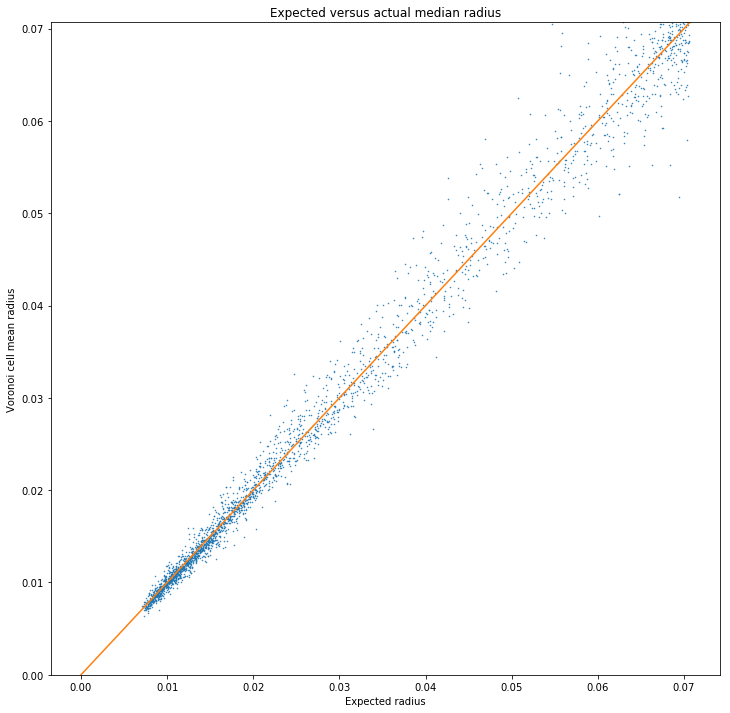

In [11]:
plt.figure()
plt.plot(np.sqrt(expected_areas), vor.median_diams, 'o', markersize=0.5)
max_size = np.max(np.sqrt(expected_areas))
plt.ylim(0,max_size)
plt.plot([0,max_size],[0,max_size], 'C1')
plt.xlabel("Expected radius")
plt.ylabel("Voronoi cell mean radius")
plt.title("Expected versus actual median radius")

## Quadrat test
We can compute the number of points in a given radius around any given test point (x,y) and compare it to the expected number of points in that radius.

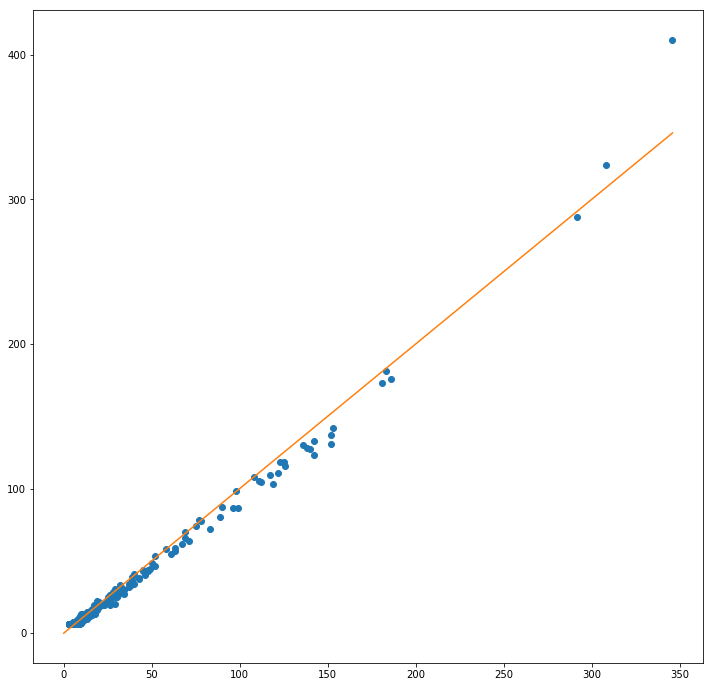

In [12]:
n = 500
test_pts = np.random.uniform(-1,1,(n,2))
test_radius = 0.1
distances = np.zeros((n,2))
for i in range(n):
    distance = np.sqrt(np.sum((test_pts[i,:] - nodes)**2, axis=1))
    
    distances[i,0] = np.sum(distance<test_radius)
    distances[i,1] = inv_density_fn(test_pts[i,0], test_pts[i,1]) * (test_radius**2*np.pi)
  
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(distances[:,0], distances[:,1])
mx = max(distances[:,0])

ax.plot([0,mx], [0,mx], 'C1')
    


## KDE plots
We can also try and recover the density function from the points, using a kernel density estimate.
**Note: the scaling of these plots is not comparable!**

In [13]:
import scipy.stats
bw = 0.1
kde = scipy.stats.gaussian_kde(nodes.T, bw)


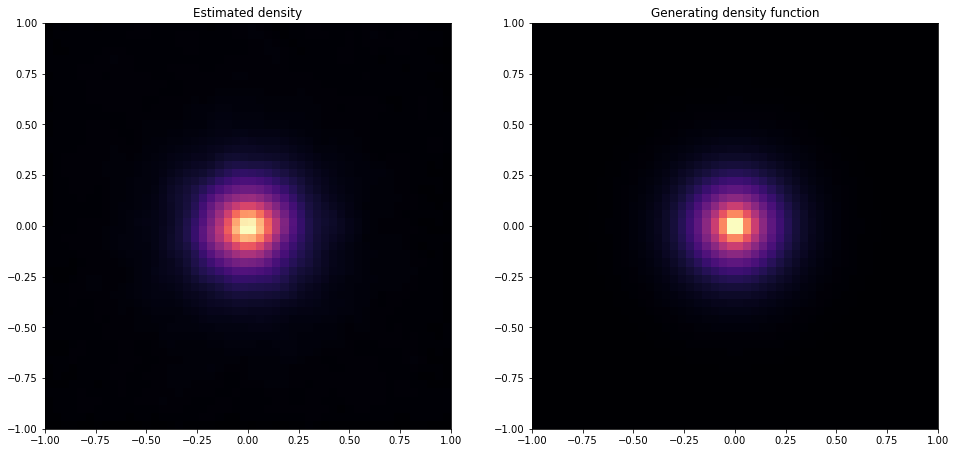

In [14]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# density function
grid_space = np.linspace(-1,1,50)
grid_x, grid_y = np.meshgrid(grid_space, grid_space)
xs = np.stack([grid_x.ravel(), grid_y.ravel()])
kde_z = np.reshape(kde(xs).T, grid_x.shape) 

kde_zimg = ax1.imshow(kde_z, extent=[-1,1,-1,1], cmap='magma')
ax1.set_title("Estimated density")

z =  inv_density_fn(grid_x, grid_y)
zimg = ax2.imshow(z, extent=[-1,1,-1,1], cmap='magma')
ax2.set_title("Generating density function")
